## Create LMDB from EPFL segmentation set
On this notebook we will create a LMDB dataset from EPFL segmentation set data. On this dataset there are 1 classe, the information os organized as follows:
* Image files (Train in /images)
* Anotation (/groundtruth)
* Kaggle (/test_set_images)




### References
* https://www.kaggle.com/c/epfml17-segmentation

In [9]:
import lmdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from os import walk
import scipy.misc as misc

# Some constant definitions
#FOLDER = 'C:/Users/sara/Documents/MachineLearning/Projects/Proj1/project2/scripts/training3_no9291'
FOLDER = '../training/training'
TRAIN_ANOTATION = FOLDER+'/groundtruth/'
TRAIN_IMAGES = FOLDER+'/images/'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
#IMAGE_WIDTH = 200
#IMAGE_HEIGHT = 200
LMDB_PATH = '../training/training'
PIXEL_THRESH = 191 #pixel threshold for black and white

def img_to_label(img):
    label = img
    label[ label < PIXEL_THRESH] = 0
    label[ label >= PIXEL_THRESH] = 1
    return label
    
    


### Display input/label train images
Observe that the key to find the match between input image and label is the filename. Also observe that the label images has png extension.

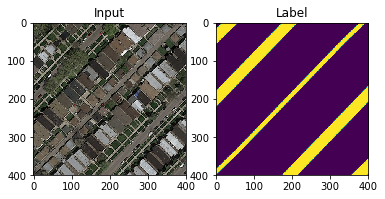

(400, 400)
[ 0.05098039  0.00784314  0.00784314  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0. 

In [11]:
fig = plt.figure()
a=fig.add_subplot(1,2,1)
img_input = mpimg.imread(TRAIN_IMAGES + 'satImage_961.png')
img_label = mpimg.imread(TRAIN_ANOTATION + 'satImage_961.png')
plt.imshow(img_input)
a.set_title('Input')
a=fig.add_subplot(1,2,2)
plt.imshow(img_label)
a.set_title('Label')
plt.show()
print(img_label.shape)
print(img_label[:,60])

In [3]:
from PIL import Image
lab = Image.open(TRAIN_ANOTATION + 'satImage_001.png')

label = misc.imread(TRAIN_ANOTATION + 'satImage_001.png')
l = lab.convert('1')
#label=(misc.imresize(label,[IMAGE_HEIGHT, IMAGE_WIDTH], interp='nearest'))
print(label[0])
label=img_to_label(misc.imresize(label,[IMAGE_HEIGHT, IMAGE_WIDTH], interp='nearest'))
print(label.shape)
print(label[0])



[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0 187 237 234 237 237 237 237 237 237 235
 237 209   4   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   2   0  49 237 235 236 237 237 237 237
 237 237 237 237 237 237 237 237 237 237 237 237 237 237 237 237 237 237
 237 237 233 237 131   0   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### Create list of path to every image on train/label
Also we load both image input and label to a list

In [12]:
dataset = []

# Get list of all files inside directory TRAIN_IMAGES
list_images_train = os.listdir(TRAIN_IMAGES)

# Iterate the list, loading the image and matching label
for img_path in list_images_train:
    # Get the sample name
    sample = img_path.split('.')[0]
    label_name = sample+'.png'
    img_path = TRAIN_IMAGES + img_path
    label_path = TRAIN_ANOTATION + label_name
    
    # Read images and resize
    img = misc.imread(img_path)
    label = misc.imread(label_path)
    img = misc.imresize(img,[IMAGE_HEIGHT, IMAGE_WIDTH], interp='nearest')
    label = img_to_label(misc.imresize(label,[IMAGE_HEIGHT, IMAGE_WIDTH], interp='nearest'))  
    if img.shape != (IMAGE_WIDTH,IMAGE_WIDTH,3):
        print('Error image shape:', img_path, 'shape:', img.shape)
        continue
    
    if label.shape != (IMAGE_WIDTH,IMAGE_WIDTH):
        print('Error label shape:', label_path, 'shape:', label.shape)
        continue
    
    # Append image and label tupples to the dataset list
    dataset.append((img,label))        


### Shuffle dataset

In [13]:
random.shuffle(dataset)
print('Dataset size:', len(dataset))

Dataset size: 7100


### Calculate sizes

In [14]:
# get size in bytes of lists
size_bytes_images = dataset[0][0].nbytes * len(dataset)
size_bytes_labels = dataset[0][1].nbytes * len(dataset)
total_size = size_bytes_images + size_bytes_labels
print('Total size(bytes): %d' % (size_bytes_images+size_bytes_labels))

Total size(bytes): 1424998400


### Create LMDB File

In [15]:
# Open LMDB file
# You can append more information up to the total size.
env = lmdb.open(LMDB_PATH, map_size=total_size+total_size/2)

### Add information on LMDB file

In [16]:
# Counter to keep track of LMDB index
idx_lmdb = 0
# Get a write lmdb transaction, lmdb store stuff with a key,value(in bytes) format
with env.begin(write=True) as txn:
    # Iterate on batch    
    for (tup_element) in dataset:
        img,label = tup_element        
        
        # Get image shapes
        shape_str_img = '_'.join([str(dim) for dim in img.shape])
        shape_str_label = '_'.join([str(dim) for dim in label.shape])
        
        label_id = ('label_{:08}_'+shape_str_label).format(idx_lmdb)   
        # Encode shape information on key
        img_id = ('img_{:08}_'+shape_str_img).format(idx_lmdb)           
        # Put data
        txn.put(bytes(label_id.encode('ascii')),label.tobytes())                
        txn.put(bytes(img_id.encode('ascii')),img.tobytes())                        
        idx_lmdb += 1